In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
if not os.path.exists('facial_keypoints.npz'):
  !wget -O facial_keypoints.npz "https://www.dropbox.com/scl/fi/27qggijmythfjg04s24xq/facial_keypoints.npz?rlkey=h91gwodhrfuz8hrc7ux9qnq7s&dl=1"

In [3]:
data = np.load('facial_keypoints.npz')
images = data['images']
keypoints = data['keypoints']

# Data Visualization

In [4]:
print("Images shape:", images.shape)
print("Images dtype:", images.dtype)
print("Images min:", np.min(images))
print("Images max:", np.max(images))

Images shape: (7049, 1, 96, 96)
Images dtype: int64
Images min: 0
Images max: 255


In [5]:
print("Keypoints shape:", keypoints.shape)
print("Keypoints dtype:", keypoints.dtype)
print("Keypoints min:", np.nanmin(keypoints))
print("Keypoints max:", np.nanmax(keypoints))

Keypoints shape: (7049, 30)
Keypoints dtype: float32
Keypoints min: 0.686592
Keypoints max: 95.935646


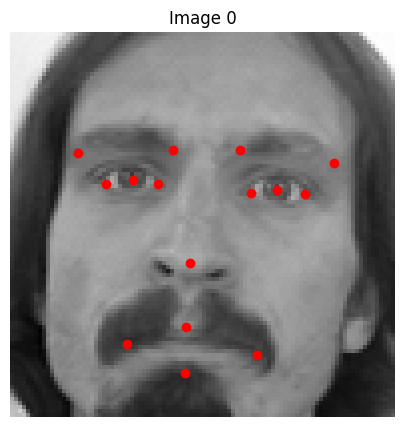

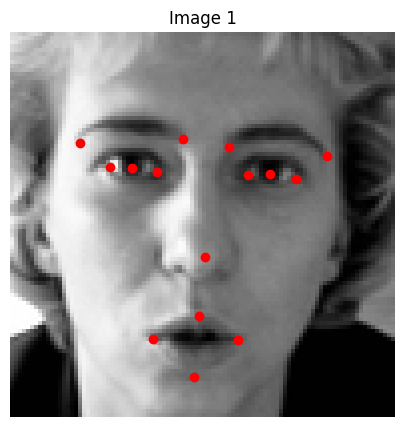

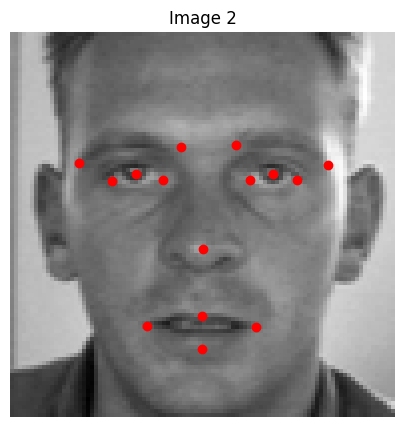

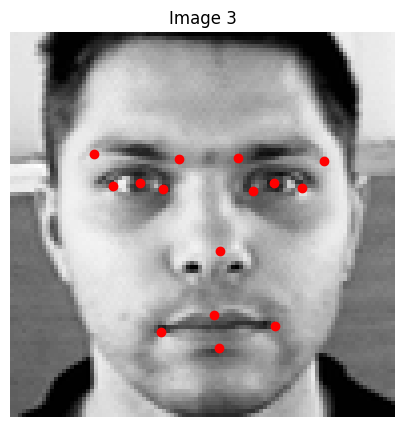

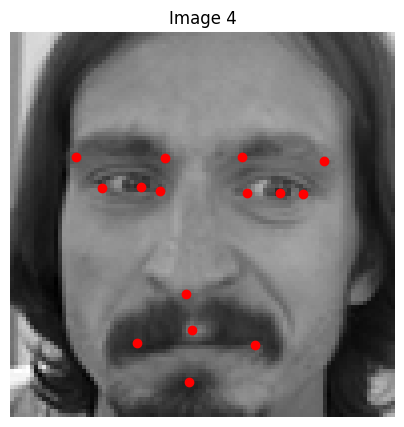

In [6]:
nsamples = 5
for i in range(nsamples):
    plt.figure(figsize=(5, 5))
    plt.imshow(images[i].squeeze(), cmap='gray')
    kp = keypoints[i].reshape(-1,2)
    valid = ~np.isnan(kp).any(axis=1)
    kp = kp[valid]
    plt.plot(kp[:,0], kp[:,1], 'ro')
    plt.title(f"Image {i}")
    plt.axis('off')
    plt.show()

# Preprocessing

In [7]:
images = images.astype(np.float32) / 255.0 # normalize to 0-1
images = np.expand_dims(images, axis=1)

kp_min = np.nanmin(keypoints, axis=0)
kp_max = np.nanmax(keypoints, axis=0)
kp_scaled = (keypoints - kp_min) / (kp_max - kp_min)

imgs_tensor = torch.tensor(images, dtype=torch.float32)
kps_tensor = torch.tensor(kp_scaled, dtype=torch.float32)

dataset = TensorDataset(imgs_tensor, kps_tensor)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Baseline

### Model Architecture

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            # 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 30)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [9]:
def masked_mae_loss(y_pred, y_true):
    mask = 1-torch.isnan(y_true).float()
    diff = torch.abs(y_true-y_pred)
    return torch.nansum(diff*mask)/torch.nansum(mask)

### Training

In [10]:
def train_model(model, train_loader, test_loader, num_epochs=50, device='cuda', threshold=0.05):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for imgs, kps in train_loader:
            imgs = imgs.to(device)
            kps = kps.to(device)
            optimizer.zero_grad()
            imgs = imgs.squeeze(1) if imgs.dim() == 5 else imgs
            outputs = model(imgs)
            loss = masked_mae_loss(outputs, kps)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for imgs, kps in test_loader:
                imgs = imgs.to(device)
                kps = kps.to(device)
                imgs = imgs.squeeze(1)
                outputs = model(imgs)
                diff = torch.abs(outputs - kps)
                mask = ~torch.isnan(kps)
                total += mask.sum().item()
                correct += ((diff < threshold) & mask).sum() .item()
        accuracy = correct / total * 100
        model.train()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}")

In [11]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    with torch.no_grad():
        for imgs, kps in test_loader:
            imgs = imgs.to(device)
            imgs = imgs.squeeze(1)
            kps = kps.to(device)
            preds = model(imgs)
            imgs_np = imgs.cpu().numpy()
            preds_np = preds.cpu().numpy()
            kps_np   = kps.cpu().numpy()
            for i in range(min(5, imgs_np.shape[0])):
                plt.figure(figsize=(4,4))
                plt.imshow(imgs_np[i, 0, :, :], cmap='gray')
                pred_kp = preds_np[i] * (kp_max - kp_min) + kp_min
                true_kp = kps_np[i]   * (kp_max - kp_min) + kp_min
                pred_kp = pred_kp.reshape(-1, 2)
                true_kp = true_kp.reshape(-1, 2)
                valid_pred = ~np.isnan(pred_kp).any(axis=1)
                valid_true = ~np.isnan(true_kp).any(axis=1)
                plt.plot(true_kp[valid_true, 0], true_kp[valid_true, 1], 'g*', markersize=10, label='Ground Truth')
                plt.plot(pred_kp[valid_pred, 0], pred_kp[valid_pred, 1], 'r.', markersize=10, label='Predicted')
                plt.legend()
                plt.title("Baseline Model Prediction")
                plt.axis('off')
                plt.show()
            break

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")
model = CNN().to(device)
train_model(model, train_loader, test_loader)

Training on device: cuda
Epoch 1/50, Loss: 0.0925, Accuracy: 58.46
Epoch 2/50, Loss: 0.0616, Accuracy: 60.83
Epoch 3/50, Loss: 0.0594, Accuracy: 57.31
Epoch 4/50, Loss: 0.0568, Accuracy: 70.96
Epoch 5/50, Loss: 0.0546, Accuracy: 70.15
Epoch 6/50, Loss: 0.0531, Accuracy: 66.83
Epoch 7/50, Loss: 0.0526, Accuracy: 70.60
Epoch 8/50, Loss: 0.0523, Accuracy: 68.16
Epoch 9/50, Loss: 0.0511, Accuracy: 70.19
Epoch 10/50, Loss: 0.0501, Accuracy: 71.12
Epoch 11/50, Loss: 0.0493, Accuracy: 70.84
Epoch 12/50, Loss: 0.0489, Accuracy: 71.04
Epoch 13/50, Loss: 0.0487, Accuracy: 71.02
Epoch 14/50, Loss: 0.0480, Accuracy: 71.14
Epoch 15/50, Loss: 0.0476, Accuracy: 71.33
Epoch 16/50, Loss: 0.0469, Accuracy: 71.19
Epoch 17/50, Loss: 0.0462, Accuracy: 72.08
Epoch 18/50, Loss: 0.0447, Accuracy: 73.90
Epoch 19/50, Loss: 0.0422, Accuracy: 75.91
Epoch 20/50, Loss: 0.0394, Accuracy: 79.74
Epoch 21/50, Loss: 0.0369, Accuracy: 82.61
Epoch 22/50, Loss: 0.0351, Accuracy: 84.11
Epoch 23/50, Loss: 0.0339, Accuracy: 8

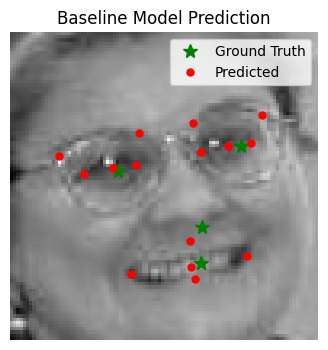

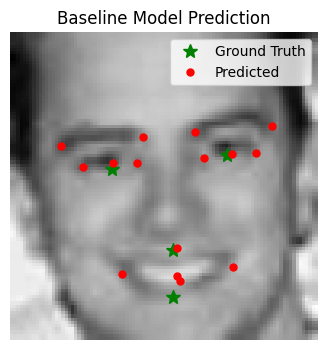

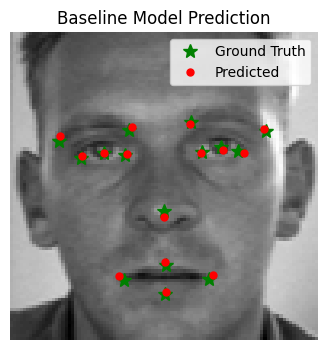

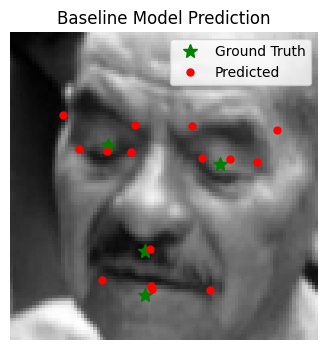

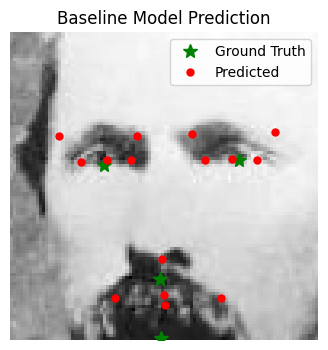

In [13]:
evaluate_model(model, test_loader)

# Improvement 1 - Updated Training with Early Stopping

In [14]:
def train_model_with_early_stopping(model, train_loader, test_loader, num_epochs=50, device='cuda', threshold=0.05, patience = 5):
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for imgs, kps in train_loader:
            imgs = imgs.to(device)
            kps = kps.to(device)
            optimizer.zero_grad()
            imgs = imgs.squeeze(1) if imgs.dim() == 5 else imgs
            outputs = model(imgs)
            loss = masked_mae_loss(outputs, kps)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        total = 0
        correct = 0
        with torch.no_grad():
            for imgs, kps in test_loader:
                imgs = imgs.to(device)
                kps = kps.to(device)
                imgs = imgs.squeeze(1) if imgs.dim() == 5 else imgs
                outputs = model(imgs)

                loss = masked_mae_loss(outputs, kps)
                val_loss += loss.item() * imgs.size(0)

                diff = torch.abs(outputs - kps)
                mask = ~torch.isnan(kps)
                total += mask.sum().item()
                correct += ((diff < threshold) & mask).sum() .item()
        val_loss /= len(test_loader.dataset)
        accuracy = correct / total * 100
        model.train()
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            if best_model_state is not None:
                model.load_state_dict(best_model_state)
            break

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")
model = CNN().to(device)
train_model_with_early_stopping(model, train_loader, test_loader)

Training on device: cuda
Epoch 1/50, Training Loss: 0.1036, Validation Loss: 0.0423, Accuracy: 70.48
Epoch 2/50, Training Loss: 0.0621, Validation Loss: 0.0450, Accuracy: 67.70
Epoch 3/50, Training Loss: 0.0579, Validation Loss: 0.0423, Accuracy: 70.32
Epoch 4/50, Training Loss: 0.0551, Validation Loss: 0.0433, Accuracy: 69.42
Epoch 5/50, Training Loss: 0.0547, Validation Loss: 0.0432, Accuracy: 69.59
Epoch 6/50, Training Loss: 0.0526, Validation Loss: 0.0477, Accuracy: 64.55
Early stopping at epoch 6


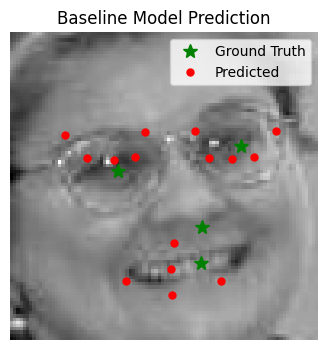

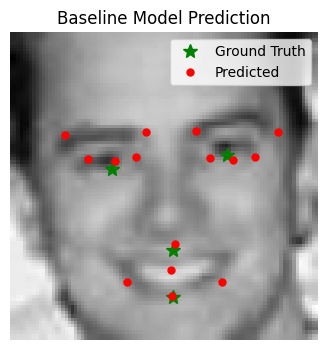

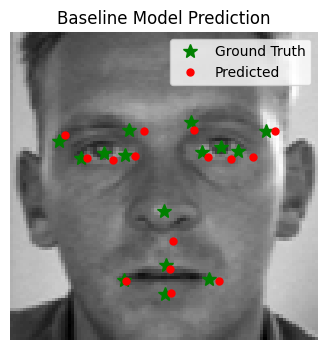

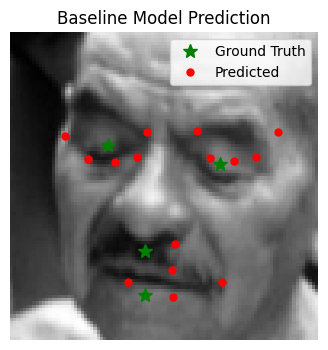

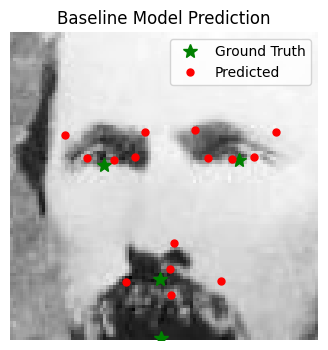

In [16]:
evaluate_model(model, test_loader)

# Improvement 2 - Updated Architecture

In [17]:
class CNNUpdatedArchitecture(nn.Module):
    def __init__(self):
        super(CNNUpdatedArchitecture, self).__init__()
        self.features = nn.Sequential(
            # Block 1 with BatchNorm
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Block 2 with BatchNorm
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Block 3 with BatchNorm
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 30)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")
model = CNNUpdatedArchitecture().to(device)
train_model_with_early_stopping(model, train_loader, test_loader)

Training on device: cuda
Epoch 1/50, Training Loss: 0.4776, Validation Loss: 0.0912, Accuracy: 41.83
Epoch 2/50, Training Loss: 0.1624, Validation Loss: 0.0934, Accuracy: 25.67
Epoch 3/50, Training Loss: 0.1349, Validation Loss: 0.0922, Accuracy: 26.68
Epoch 4/50, Training Loss: 0.1096, Validation Loss: 0.0740, Accuracy: 41.04
Epoch 5/50, Training Loss: 0.0866, Validation Loss: 0.0636, Accuracy: 48.85
Epoch 6/50, Training Loss: 0.0691, Validation Loss: 0.0509, Accuracy: 61.23
Epoch 7/50, Training Loss: 0.0572, Validation Loss: 0.0479, Accuracy: 64.35
Epoch 8/50, Training Loss: 0.0495, Validation Loss: 0.0439, Accuracy: 68.41
Epoch 9/50, Training Loss: 0.0454, Validation Loss: 0.0415, Accuracy: 71.36
Epoch 10/50, Training Loss: 0.0431, Validation Loss: 0.0408, Accuracy: 72.03
Epoch 11/50, Training Loss: 0.0420, Validation Loss: 0.0397, Accuracy: 72.77
Epoch 12/50, Training Loss: 0.0413, Validation Loss: 0.0385, Accuracy: 73.99
Epoch 13/50, Training Loss: 0.0408, Validation Loss: 0.0388,

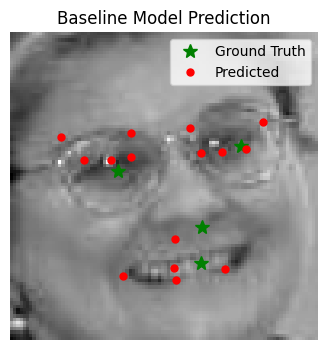

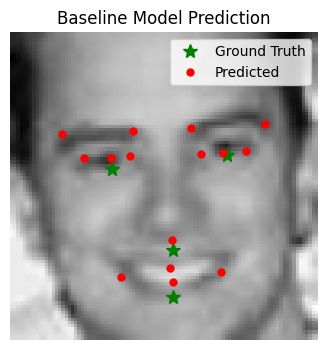

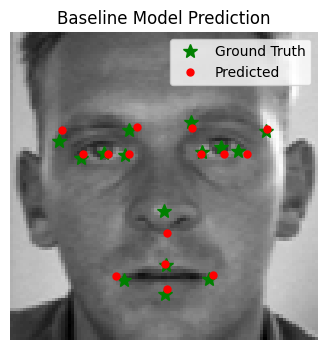

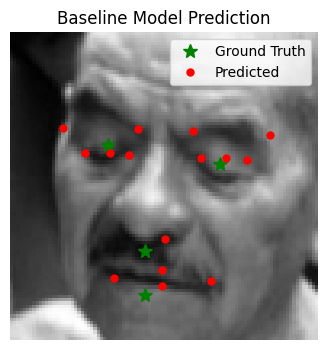

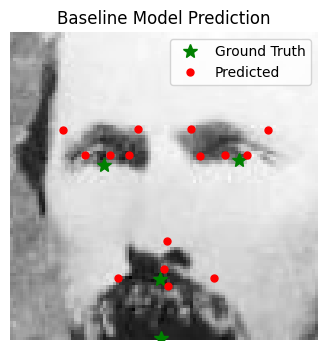

In [19]:
evaluate_model(model, test_loader)